# F2Heal - PAC analysis



## Intro

In this notbook we try to reproduce the results of Swan et al. in "Elevated Synchrony in Parkinson's Disease Detected with
Electroencephalography" using Python.

The following domain specific Python libraries are used:
* [MNE-Python](https://mne.tools/)
* [pactools](https://github.com/pactools/pactools)
* [openneuro-py](https://pypi.org/project/openneuro-py/)

The following general libraries are used:
* [NumPy](https://numpy.org/)
* [MatplotLib](https://matplotlib.org/)

We will use the San Diego dataset [published on OpenNeuro](https://openneuro.org/datasets/ds002778)

## Preparation

As a starter, we like it open source...

In [2]:
# SPDX-License-Identifier: AGPL-3.0-or-later

Install required python packages for this notebook

In [3]:
%pip install mne mne_bids pactools openneuro-py autoreject

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.7/43.7 kB 872.5 kB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.3 MB/s eta 0:00:00ta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 55.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 22.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 2.0 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.4/40.4 kB 850.4 kB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 1.4 MB/s eta 0:00:000:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 33.3 MB/s eta 0:00:0000:01:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.6/81.6 kB 1.7 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.3/78.3 kB 1.8 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 97.9/97.9 kB 2.3 MB/s eta 0:00:00eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Pyhton script

### Setting the scene

Here the Python script starts by importing all required libraries

In [4]:
import mne
import mne_bids
import openneuro

import autoreject

import numpy as np
import pactools
import matplotlib.pyplot as plt

/home/codespace/.python/current/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


We introduce a configurable parameter. Change the verbose parameter to `False` for less output.

In [10]:
verbose = True

Next, we'll define a class with configuration data describing the OpenNeuro dataset that will be used from here on.

In [11]:
class ONDataset:
    """
    Open EEG dataset from OpenNeuro
    Parkinson's EEG dataset <https://openneuro.org/datasets/ds002778
    """
    dataset = 'ds002778'
    bids_root = "/tmp/mne"
    datatype = 'eeg'
    task = 'rest'
    suffix = 'eeg'


Next, we'll also define a class with configuration parameters relevant for the PAC generation.

Note that you can specify the PAC method here. Valid methods are:  `'tort', 'penny', 'vanwijk', 'duprelatour', 'colgin', 'sigl', 'bispectrum'`

Swan et al. have used the equivalent of the `'tort'` method in MATLAB. This method does not produce similar results in MNE-Python. The method `'duprelatour'` does. See [this Github issue](https://github.com/pactools/pactools/issues/33) for more details.

In [12]:
class PACSettings:
    low_fq_range = np.linspace(13,50,150)
    low_fq_width = 2
    high_fq_range= np.linspace(50,200,150)
    high_fq_width= 4
    method= 'duprelatour'

    def create_Comodulogram(fs):
        return pactools.Comodulogram (fs=fs,
                                      low_fq_range=PACSettings.low_fq_range,
                                      low_fq_width=PACSettings.low_fq_width,
                                      high_fq_range=PACSettings.high_fq_range,
                                      high_fq_width=PACSettings.high_fq_width,
                                      method=PACSettings.method,
                                      progress_bar=verbose,
                                      n_jobs=16)

### Loading the OpenNeuro data

We need to pick a valid subject from the OpenNeuro dataset. You can pick an ID from: 3, 5, 6, 9, 11, 12, 13, 14, 16, 17, 19, 22, 23, 26, 28

In [13]:
subject = "pd6"

Next, we'll download the relevant EEG session for this subject from OpenNeuro. You might need to restart this step a second time if it fails at first.

In [14]:
def fetch_raw(subject, session):

    openneuro.download(dataset=ONDataset.dataset, target_dir=ONDataset.bids_root, include=[f"sub-{subject}"])
    bids_path = mne_bids.BIDSPath(root=ONDataset.bids_root,
                         task=ONDataset.task, suffix=ONDataset.suffix,
                         datatype=ONDataset.datatype, session=session,
                         subject=subject )

    raw = mne.io.read_raw_bdf(bids_path, verbose=verbose, preload=True)

    return raw

raw_on = fetch_raw(subject, 'on')


👋 Hello! This is openneuro-py 2024.2.0. Great to see you! 🤗

   👉 Please report problems 🤯 and bugs 🪲 at
      https://github.com/hoechenberger/openneuro-py/issues

🌍 Preparing to download ds002778 …


📁 Traversing directories for ds002778 : 20 entities [00:06,  3.00 entities/s]

📥 Retrieving up to 19 files (5 concurrent downloads). 
✅ Finished downloading ds002778.
 
🧠 Please enjoy your brains.
 
Extracting EDF parameters from /tmp/mne/sub-pd6/ses-on/eeg/sub-pd6_ses-on_task-rest_eeg.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 147967  =      0.000 ...   288.998 secs...


### Data inspection (optional)

This data has now been loaded in a MNE-Python `raw` structure, that we can inspect:

In [15]:
print(raw_on.info)
print(raw_on.info["subject_info"])

<Info | 8 non-empty values
 bads: []
 ch_names: Fp1, AF3, F7, F3, FC1, FC5, T7, C3, CP1, CP5, P7, P3, Pz, PO3, ...
 chs: 40 EEG, 1 Stimulus
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 256.0 Hz
 meas_date: 2020-04-22 23:50:12 UTC
 nchan: 41
 projs: []
 sfreq: 512.0 Hz
 subject_info: 4 items (dict)
>
{'his_id': 'X', 'sex': 0, 'last_name': 'Anonymous', 'birthday': (1951, 5, 13)}


We can also visulaize the raw stream:

Using matplotlib as 2D backend.


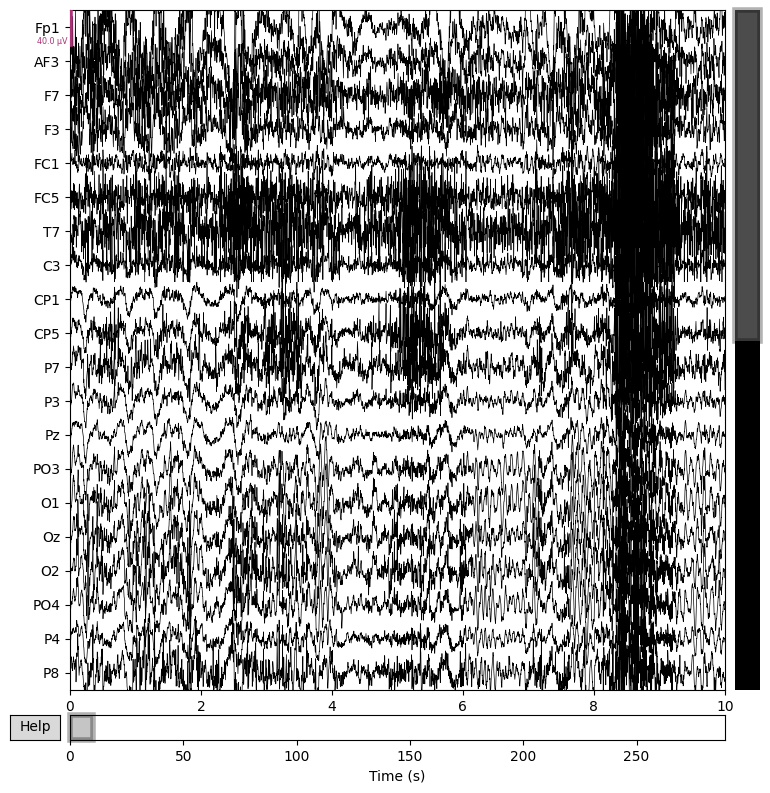

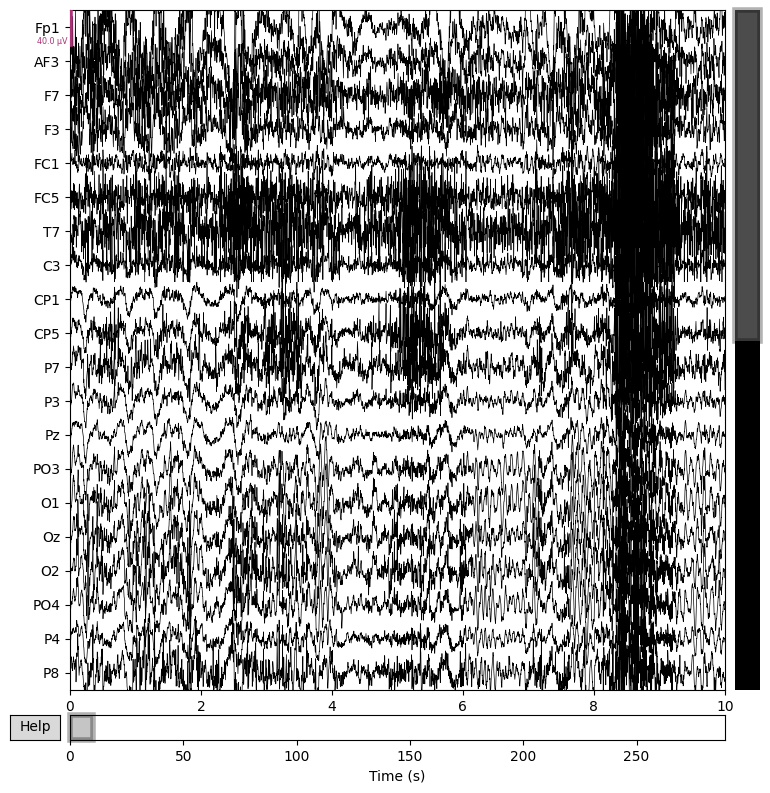

In [16]:
raw_on.plot()

and the PSD:

Effective window size : 4.000 (s)


Plotting power spectral density (dB=True).


/tmp/ipykernel_14464/3056736814.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_on.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)


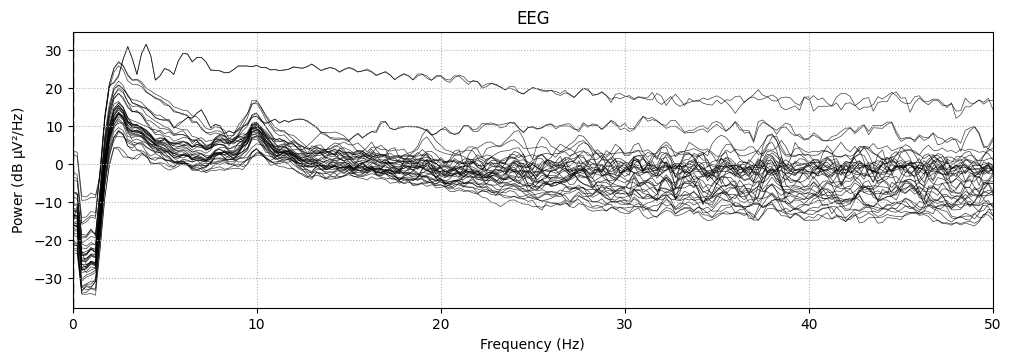

In [18]:
raw_on.compute_psd(fmax=50).plot(picks="data", exclude="bads", amplitude=False)

### Preprocessing

We drop a number of channels from the recording not needed for further analysis.

In [ ]:
raw_on.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4','EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status'])

Set the correct headset montage details, specify the model mentioned by George et al. in "Dopaminergic therapy in Parkinson's disease decreases cortical beta band coherence in the resting state and increases cortical beta band power during executive control"

In [ ]:
raw_on.set_montage("biosemi32", verbose=verbose)

Create a new virtual electrode by averaging all channels, the re-reference the data according to this new virtual reference.

In [ ]:
raw_on.set_eeg_reference(ref_channels='average',verbose=verbose)

Apply a high-pass filter with 0.5Hz cut-off frequency

In [ ]:
raw_on.filter(0.5, None, fir_design='firwin', phase='zero-double', verbose=verbose)

Devide the current raw stream in equal epochs of 3sec length.

In [ ]:
epochs_all_on = mne.make_fixed_length_epochs(raw_on, duration=3, preload=True, verbose=verbose)

Apply the default autoreject filter

In [ ]:
ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11, verbose=verbose)
ar.fit(epochs_all_on)
epochs_on = ar.transform(epochs_all_on)

### Calculating PAC

Create a 3-element array for holding the Comodulogram objects, for electrode C3, C4 and their average respectively.

In [ ]:
pacs_on = [ PACSettings.create_Comodulogram(raw_on.info['sfreq']) for _ in range(3)]

Fit C3 data to the first element.

In [ ]:
pacs_on[0].fit(epochs_on.get_data(picks=['C3'])[:,0,:])

C4 data to the second

In [ ]:
pacs_on[1].fit(epochs_on.get_data(picks=['C4'])[:,0,:])

Average of both in the third element.

In [ ]:
pacs_on[2].comod_ = np.mean([pacs_on[0].comod_, pacs_on[1].comod_],axis=0)

Now that we have calculated the results for on-session, repeat for off-session.

In [ ]:
raw_off = fetch_raw(subject, 'off')

raw_off.drop_channels(['EXG1', 'EXG2', 'EXG3', 'EXG4','EXG5', 'EXG6', 'EXG7', 'EXG8', 'Status'])
raw_off.set_montage("biosemi32", verbose=verbose)
raw_off.set_eeg_reference(ref_channels='average',verbose=verbose)
raw_off.filter(0.5, None, fir_design='firwin', phase='zero-double', verbose=verbose)

epochs_all_off = mne.make_fixed_length_epochs(raw_off, duration=3, preload=True, verbose=verbose)
ar = autoreject.AutoReject(n_interpolate=[1, 2, 3, 4], random_state=11, verbose=verbose)
ar.fit(epochs_all_off)
epochs_off = ar.transform(epochs_all_off)

Combine the OFF results in another 3-element array.

In [ ]:
pacs_off = [ PACSettings.create_Comodulogram(raw_off.info['sfreq']) for _ in range(3)]

pacs_off[0].fit(epochs_off.get_data(picks=['C3'])[:,0,:])
pacs_off[1].fit(epochs_off.get_data(picks=['C4'])[:,0,:])
pacs_off[2].comod_ = np.mean([pacs_off[0].comod_, pacs_off[1].comod_],axis=0)

To set a common scale for the Comodulograms, we need to find the Vmax in all results.

In [ ]:
vmax = max([pac.comod_.max() for pac in np.concatenate((pacs_on, pacs_off))])

Calculate the Modulation Index (MI) for every PAC by averaging the results.

In [ ]:
mis_on  = [ np.mean(pac.comod_) for pac in pacs_on ]
mis_off = [ np.mean(pac.comod_) for pac in pacs_off ]

### Results

Print the MI values

In [ ]:
print("%s " % (subject))
print(" ON  C3:%.3E C4:%.3E AVG:%.3E" % (mis_on[0], mis_on[1], mis_on[2]))
print(" OFF C3:%.3E C4:%.3E AVG:%.3E" % (mis_off[0], mis_off[1], mis_off[2]))

Create Matplotlib object with the desired structure and size

In [ ]:
fig,axs=plt.subplots(2,3,figsize=(16,8))

plt.suptitle("Subject: %s  PAC Method: %s"
             % (subject, PACSettings.method ))

Plot the previously calculated results to it

In [ ]:
pacs_on[0].plot(titles=["ON C3 MI=%.2E"  % mis_on[0]], axs=[axs[0,0]], vmin=0, vmax=vmax)
pacs_on[1].plot(titles=["ON C4 MI=%.2E"  % mis_on[1]], axs=[axs[0,1]], vmin=0, vmax=vmax)
pacs_on[2].plot(titles=["ON AVG MI=%.2E" % mis_on[2]], axs=[axs[0,2]], vmin=0, vmax=vmax)

pacs_off[0].plot(titles=["OFF C3 MI=%.2E"  % mis_off[0]], axs=[axs[1,0]], vmin=0, vmax=vmax)
pacs_off[1].plot(titles=["OFF C4 MI=%.2E"  % mis_off[1]], axs=[axs[1,1]], vmin=0, vmax=vmax)
pacs_off[2].plot(titles=["OFF AVG MI=%.2E" % mis_off[2]], axs=[axs[1,2]], vmin=0, vmax=vmax)
